<a href="https://colab.research.google.com/github/Lvl1Programmer/DataScienceTopics/blob/main/SpeechRecognitionAOL(Speaker_Recognition).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speaker Recognition

We'll be using tensorflow and keras for this project, also it is reccomended to use GPU for this, since this takes quite a heavy load

Using FFT(Fast Fourier Transform) to make the data noise and d-vector for our model

Dataset Used:
https://www.kaggle.com/datasets/kongaevans/speaker-recognition-dataset

# Download

# Initialization

In [ ]:
#Import relevant libraries
import os
import json
import random
from google.colab import userdata
import shutil
import numpy as np
import tensorflow as tf
import keras
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import pandas as pd
from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import IPython.display as ipd
import seaborn as sns



from pathlib import Path
from IPython.display import display,Audio


In [ ]:
# Some constants to be used later
EPOCH = 2
SPLIT = 0.2
SAMPLING_RATE = 16000
SHUFFLE_SEED = 43
SCALE = 0.5
BATCH_SIZE = 128

In [ ]:
# Download Dataset from kaggle
!kaggle datasets download -d kongaevans/speaker-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/kongaevans/speaker-recognition-dataset
License(s): unknown
100% 231M/231M [00:04<00:00, 63.4MB/s]
100% 231M/231M [00:04<00:00, 51.2MB/s]


In [ ]:
# unzip file
!unzip -q speaker-recognition-dataset.zip

# Data Exploaration
In this stage, we will explore the data in this dataset a bit, and do some EDA if needed be

Steps:
1. Collecting Data and initial assessment
2. Metadata Analysis
3. Visual Inspection

## EDA
1. Audio Quality Assessment
2. Feature Extraction and Analysis
3. Class Distribution
4. Preprocessing Requirements

## 1. Collecting Data and Initial Assessment
Here we have already compiled the relevant data into the right files in the inilization step. Next step is to listen in to audio data, to get a feel of it

In [ ]:
# Saving audio_folders name for easy use later on
root_path = '/content/16000_pcm_speeches'
audio_folders = [] # list to hold names of folders


for directory_path, directory_names, file_names in os.walk(root_path):
  if directory_path != root_path:
    folder_name = os.path.basename(directory_path)
    audio_folders.append(folder_name)

In [ ]:
# Lets try sampling or listening to some of the audio files
complete_audio_files = {} #Placing all the files in dict format 'name':['files']

for folder_name in audio_folders:
  path = f'/content/16000_pcm_speeches/{folder_name}/*.wav'

  audio_files = glob(path)

  complete_audio_files[folder_name] = audio_files

In [ ]:
# Play Audio
for speaker, audio_files in complete_audio_files.items():
  print(f"{speaker} .wav first sample")
  display(ipd.Audio(audio_files[0]))

Benjamin_Netanyau .wav first sample


Jens_Stoltenberg .wav first sample


Nelson_Mandela .wav first sample


Julia_Gillard .wav first sample


_background_noise_ .wav first sample


Magaret_Tarcher .wav first sample


other .wav first sample


From this data we could see that there are not many noise in the speaker audio which indicates a good data file

## 2. Metadata Analysis

From the dataset we  required the author stated that the audio data has been parsed into 1 second audio files for each speaker audio.
While the others audio files varies in length.
This might mean, that we need to process the noise later again to make it 1 second durations to match the audio


In [ ]:
# Lets do a quick view of our dataset folder
!ls /content/16000_pcm_speeches

audio  noise  tf_Wav_reader.py


In [ ]:
# Finding out how much number of files in each files
# in the 16000_pcm_speeches file
total_files = 0 # Keeps track of the total amount of files in the dataset

for directory_path, directory_names, file_names in os.walk(root_path):
  if directory_path != root_path:
    number_of_files = len(file_names)
    folder_name = os.path.basename(directory_path)
    print(f"There are {number_of_files} files in {folder_name}")
    total_files += number_of_files

print(f"Totaling to {total_files} audio files in this dataset.")

There are 0 files in audio
There are 1500 files in Benjamin_Netanyau
There are 1500 files in Nelson_Mandela
There are 1500 files in Magaret_Tarcher
There are 1501 files in Julia_Gillard
There are 1500 files in Jens_Stoltenberg
There are 0 files in noise
There are 2 files in other
There are 4 files in _background_noise_
Totaling to 7507 audio files in this dataset.


The audio files are sorted according to their speaker names and noises to two different files, one which are background noises and other

We could also see there is a tf_Wav_reader.py that is not part of the dataset and just leftovers

In [ ]:
# Lets see its sample rate and data of a audio file from Benjamin Netanyau
raw_data, sample_rate = librosa.load(complete_audio_files['Benjamin_Netanyau'][0]
                                     ,sr=None)
print(f'The raw data: {raw_data}')
print(f'The shape of the data {raw_data.shape}')
print(f'The sample rate is : {sample_rate} pcm')

IndexError: list index out of range

## 3. Visual Insepction

Here we will plot the waveform and spectogram to help visualize the data

In [ ]:
# Here we will try see the data from Benjamin Netanyau
# Waveform
plt.figure(figsize=(10,4))
librosa.display.waveshow(raw_data,sr=sample_rate)
plt.title('Waveform of Benjamin Netanyau audio sample 1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (m)')
plt.show()

NameError: name 'raw_data' is not defined

<Figure size 1000x400 with 0 Axes>

From this data we can see that there aren't much silence here, so there won't be any trimming or zoom needed  


In [ ]:
# Spectogram
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(raw_data)), ref=np.max)
librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Benjamin Netanyau audio sample 1')
plt.show()

NameError: name 'raw_data' is not defined

<Figure size 1000x400 with 0 Axes>

In [ ]:
# The shape of the array after soft fourirer transform
D.shape

In [ ]:
# Mel-spectogram
S = librosa.feature.melspectrogram(y=raw_data,sr = sample_rate, n_mels = 128,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db_mel, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram of Benjamain Netanyau audio sample 1')
plt.show()

In [ ]:
# MFCC
mfccs = librosa.feature.mfcc(y=raw_data, sr=sample_rate, n_mfcc=13, hop_length=512)
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC of Benjamain Netanyau audio sample 1')
plt.show()
print(f"Shape: {mfccs.shape}")

From these graph above we could see the audio data sample is dense with information.
Also, it can be seen we have extracted 13 MFCCs

## EDA

For futher analysis of data

### 1. Audio Quality Assessment

In [ ]:
# Check if they are all truly 1 second audio file

def check_audio_length(audio_path):
  y, sr = librosa.load(audio_path, sr=None)
  return librosa.get_duration(y=y, sr=sr) == 1

# Check if clipping
def check_clipping(y):
  return np.max(np.abs(y)) == 1

# Check volume consistency
def volume_consistency(y):
  return np.mean(librosa.amplitude_to_db(y))

clipping = []
volume = []
durations = []
speaker = ""
sample = ""
for speaker, audio_files in complete_audio_files.items():
  if(speaker.lower() == '_background_noise_' or speaker.lower() == 'other'):
    continue
    #Skips both background noise and other file becuase we are looking for speaker files
  for file in audio_files:
    audio_path = os.path.join(speaker,file)
    y,sr = librosa.load(audio_path, sr=None)
    if(check_clipping(y) or volume_consistency(y) or check_audio_length(audio_path)):
      speaker = speaker
      sample = audio_path
    clipping.append(check_clipping(y))
    volume.append(volume_consistency(y))
    durations.append(check_audio_length(audio_path))


print(f"Clipping: {all(clipping)}")
print(f"Volume Consistency: {all(volume)}")
print(f"Audio Length: {all(durations)}")

# Also check a sample audio to get a gist of attributes above
print(f"Sample Speaker: {speaker}")
print(f"Audio File Name: {sample}")
display(ipd.Audio(sample))

In conclusion there are some audio that clips. Which might be good for model as it can introduce noise for generalizability of the model. We won't be touching the clipping audios.



### 2. Feature Extraction and Analysis


In this stage, I want to see the distribution of MFCCs accross the dataset. To see if there's any pattern that might be useful

In [ ]:
# Count MFCC
def extract_mfcc(audio_path):
  y, sr = librosa.load(audio_path, sr=None)
  mfcss = librosa.feature.mfcc(y=y,sr=sr, n_mfcc=13)
  return mfccs

mfcc_features = {}

for speaker, audio_files in complete_audio_files.items():
  if(speaker.lower() == '_background_noise_' or speaker.lower() == 'other'):
    continue
  mfcc_features[speaker] = []
  for file in audio_files:
    audio_path = os.path.join(speaker,file)
    mfccs = extract_mfcc(audio_path)
    mfcc_features[speaker].append(mfccs)


In [ ]:
plt.figure(figsize=(20,30))

num_mfcc = len(next(iter(mfcc_features.values()))[0])

# Plotting each MFCC dimension
for i in range(13):
  plt.subplot(13,1, i+1)
  for speaker, features in mfcc_features.items():
    mfcc_values = np.array([features[i] for feature in features]).flatten()
    plt.hist(mfcc_values, bins=20, alpha=0.5, label=speaker)
  plt.title(f'MFCC {i+1}')
  plt.xlabel('MFCC Value')
  plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Finding Mean and Std
mfcc_mean = {}
mfcc_std = {}
for speaker, features in mfcc_features.items():
  mfcc_mean[speaker] = np.mean(features, axis=0)
  mfcc_std[speaker] = np.std(features, axis=0)
  print(f"Speaker: {speaker}, Mean MFCCs: {mfcc_mean}, Std MFCCs: {mfcc_std}")

In [ ]:
plt.figure(figsize=(10, 6))
legend_labels = []
for speaker, mean in mfcc_mean.items():
    plt.plot(mean, label=f'{speaker} Mean', alpha=0.7)
    flattened_mean = np.asarray(mean).flatten()
    flattened_std = np.asarray(mfcc_std[speaker]).flatten()
    plt.fill_between(range(len(flattened_mean)), flattened_mean - flattened_std, flattened_mean + flattened_std, color='black', alpha=0.2)
    if f'{speaker} Mean' not in legend_labels:
        legend_labels.append(f'{speaker} Mean')
    if f'{speaker} Std' not in legend_labels:
        legend_labels.append(f'{speaker} Std')
plt.title('Mean and Standard Deviation of MFCCs')
plt.xlabel('MFCC Index')
plt.ylabel('Value')
plt.grid(True)

plt.xlim(0, 13)
plt.ylim(None, None)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(legend_labels)], legend_labels)
plt.show()


Black = Variance around mean


On the other hand there aren't much pattern that's interesting here

### 3. Class Distribution

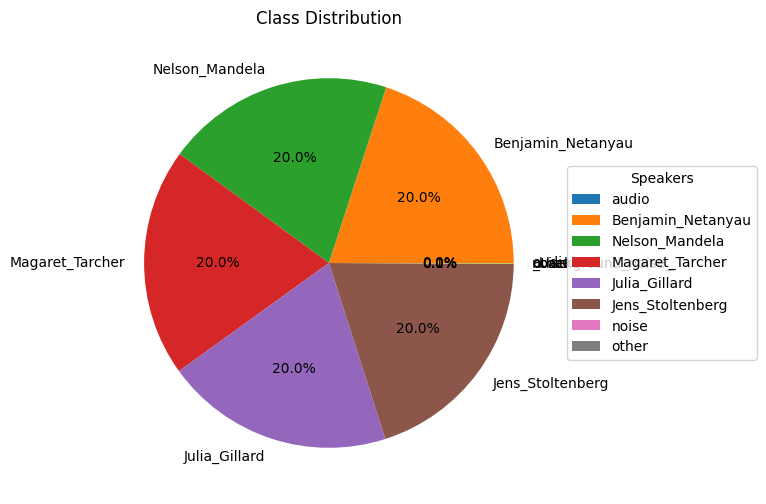

In [ ]:
class_names = []
num = []

for directory_path, directory_names, file_names in os.walk('/content/16000_pcm_speeches'):
    if directory_path != '/content/16000_pcm_speeches' and \
       directory_path != '/content/16000_pcm_speeches/other' and \
       directory_path != '/content/16000_pcm_speeches/_background_noise_' and \
       directory_path != '/content/16000_pcm_speeches/tf_Wav_reader.py':

        number_of_files = len(file_names)
        folder_name = os.path.basename(directory_path)
        class_names.append(folder_name)
        num.append(number_of_files)

# Plot
plt.figure(figsize=(10, 6))
plt.pie(num, labels=class_names, autopct='%1.1f%%')
plt.title("Class Distribution")
plt.legend(title="Speakers", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()



### 4. Preprocessing Requirements

From the data above, i am thinking of adding noise to the speaker dataset
as they are realtively clean and i think would do better with some noise. Other than that nothing seems out of the ordinary

# Preprocessing

In this stage we will do a couple of things including:
1. Put the folders in their respective places
2. divide the noise samples into 1 second audio files so it can be added to the speaker audio files
3. Dataset Generation


In [ ]:
DATASET_ROOT = "16000_pcm_speeches"
AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)

VALID_SPLIT = 0.1
SHUFFLE_SEED = 43
SAMPLING_RATE = 16000
SCALE = 0.5

BATCH_SIZE = 128
EPOCHS = 1

for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:
            continue
        elif folder in ["other", "_background_noise_"]:
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )

Here is the step we are going to divide noise into 1 sec intervals and change sample rate to 16000 to be used on speaker dataset.

In [ ]:
# Get the list of all noise files
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]
if not noise_paths:
    raise RuntimeError(f"Could not find any files at {DATASET_NOISE_PATH}")
print(
    "Found {} files belonging to {} directories".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)

Found 6 files belonging to 2 directories


In [ ]:
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)
os.system(command)


def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} second long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 noise files were split into 354 noise samples where each is 1 second long


Dataset Generation
Here I am going to add some noise too the some of the speaker dataset and then i am going to split the data set

In [ ]:
def paths_and_labels_to_dataset(audio_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(
        lambda x: path_to_audio(x), num_parallel_calls=tf.data.AUTOTUNE
    )
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])


In [ ]:
# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print(
    "Our class names: {}".format(
        class_names,
    )
)

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print(
        "Processing speaker {}".format(
            name,
        )
    )
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Our class names: ['Magaret_Tarcher', 'Benjamin_Netanyau', 'Julia_Gillard', 'Nelson_Mandela', 'Jens_Stoltenberg']
Processing speaker Magaret_Tarcher
Processing speaker Benjamin_Netanyau
Processing speaker Julia_Gillard
Processing speaker Nelson_Mandela
Processing speaker Jens_Stoltenberg
Found 7501 files belonging to 5 classes.
Using 6751 files for training.
Using 750 files for validation.


# Model Configuration
We will be using with the help of keras deep learning for our model

In [ ]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
# 16000 Sample Rate, monoaudio
num_speakers = 5
model = build_model((16000//2,1), num_speakers)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 8000, 16)             64        ['input[0][0]']               
                                                                                                  
 activation (Activation)     (None, 8000, 16)             0         ['conv1d_1[0][0]']            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 8000, 16)             784       ['activation[0][0]']          
                                                                                              

# Model Traning

Validation test and accuracy

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model',
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         mode='min',
                                                         save_best_only=True,
                                                         verbose=1)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)


In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCH,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb]
)

Epoch 1/2
53/53 [==============================] - 30s 267ms/step - loss: 1.7101 - accuracy: 0.6601 - val_loss: 0.4110 - val_accuracy: 0.8333
Epoch 2/2
53/53 [==============================] - 10s 177ms/step - loss: 0.2949 - accuracy: 0.8874 - val_loss: 0.1851 - val_accuracy: 0.9373


# Hyperparameter Tuning
Note this took a looong time, personally we stopped it at 2hour mark and found the result to be satisfying enough. Here is an example output of the tuning


```
Value             |Best Value So Far |Hyperparameter
64                |64                |filters_1
96                |64                |filters_2
192               |64                |filters_3
256               |256               |filters_4
256               |256               |filters_5
384               |384               |dense_units_1
128               |128               |dense_units_2
0.001696          |0.00064439        |learning_rate
4                 |30                |tuner/epochs
0                 |10                |tuner/initial_epoch
2                 |3                 |tuner/bracket
0                 |3                 |tuner/round

```




In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)

def build_model(hp):
    inputs = keras.layers.Input(shape=(SAMPLING_RATE // 2, 1), name="input")

    # First residual block
    x = residual_block(inputs, hp.Int('filters_1', min_value=16, max_value=64, step=16), 2)
    # Second residual block
    x = residual_block(x, hp.Int('filters_2', min_value=32, max_value=128, step=32), 2)
    # Third residual block
    x = residual_block(x, hp.Int('filters_3', min_value=64, max_value=256, step=64), 3)
    # Fourth residual block
    x = residual_block(x, hp.Int('filters_4', min_value=128, max_value=512, step=128), 3)
    # Fifth residual block
    x = residual_block(x, hp.Int('filters_5', min_value=128, max_value=512, step=128), 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(hp.Int('dense_units_1', min_value=128, max_value=512, step=128), activation="relu")(x)
    x = keras.layers.Dense(hp.Int('dense_units_2', min_value=64, max_value=256, step=64), activation="relu")(x)

    outputs = keras.layers.Dense(len(class_names), activation="softmax", name="output")(x)

    model = keras.models.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Define the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='my_dir',
    project_name='audio_classification'
)

# Early stopping callback
earlystopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Run the hyperparameter search
tuner.search(
    train_ds,
    validation_data=valid_ds,
    epochs=50,
    callbacks=[earlystopping_cb]
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of filters in the first layer is {best_hps.get('filters_1')},
the second layer is {best_hps.get('filters_2')}, the third layer is {best_hps.get('filters_3')},
the fourth layer is {best_hps.get('filters_4')}, and the fifth layer is {best_hps.get('filters_5')}.
The best number of units in the first dense layer is {best_hps.get('dense_units_1')} and in the second dense layer is {best_hps.get('dense_units_2')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=50,
    callbacks=[earlystopping_cb]
)

Trial 75 Complete [00h 00m 37s]

Best val_accuracy So Far: 0.9933333396911621
Total elapsed time: 03h 38m 17s

Search: Running Trial #76

Value             |Best Value So Far |Hyperparameter
32                |16                |filters_1
64                |128               |filters_2
128               |64                |filters_3
256               |384               |filters_4
512               |128               |filters_5
512               |512               |dense_units_1
64                |256               |dense_units_2
0.00093371        |0.00058644        |learning_rate
10                |30                |tuner/epochs
0                 |10                |tuner/initial_epoch
1                 |3                 |tuner/bracket
0                 |3                 |tuner/round

Epoch 1/10
 6/53 [==>...........................] - ETA: 28s - loss: 19.7601 - accuracy: 0.2565

53/53 [==============================] - 111s 2s/step - loss: 2.9799 - accuracy: 0.6303 - val_loss: 0.4868 - val_accuracy: 0.7920
Epoch 2/10
53/53 [==============================] - 107s 2s/step - loss: 0.3411 - accuracy: 0.8707 - val_loss: 0.2713 - val_accuracy: 0.8760
Epoch 3/10
53/53 [==============================] - ETA: 0s - loss: 0.2519 - accuracy: 0.9003

KeyboardInterrupt: 

In [ ]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of filters in the first layer is {best_hps.get('filters_1')},
the second layer is {best_hps.get('filters_2')}, the third layer is {best_hps.get('filters_3')},
the fourth layer is {best_hps.get('filters_4')}, and the fifth layer is {best_hps.get('filters_5')}.
The best number of units in the first dense layer is {best_hps.get('dense_units_1')} and in the second dense layer is {best_hps.get('dense_units_2')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=50,
    callbacks=[earlystopping_cb]
)

NameError: name 'tuner' is not defined

In [ ]:
# Plot the tuning history
import pandas as pd
import json

# Get the tuner results directory
results_dir = os.path.join('my_dir', 'audio_classification')

# Load the tuning results from the directory
tuning_results = []
for trial_dir in os.listdir(results_dir):
    if 'trial' in trial_dir:
        trial_path = os.path.join(results_dir, trial_dir)
        trial_summary = pd.read_json(os.path.join(trial_path, 'trial.json'))
        tuning_results.append(trial_summary)

# Concatenate all trial summaries
tuning_results_df = pd.concat(tuning_results, ignore_index=True)

# Parse the metrics column to extract step (epoch) and val_accuracy
tuning_results = []
for idx, row in tuning_results_df.iterrows():
    if pd.notna(row['metrics']):
        metrics = json.loads(row['metrics'].replace("'", "\""))
        if 'val_accuracy' in metrics:
            for obs in metrics['val_accuracy']['observations']:
                tuning_results.append({
                    'trial_id': row['trial_id'],
                    'epoch': obs['step'],
                    'val_accuracy': obs['value'][0]
                })

# Convert to DataFrame
tuning_results_parsed_df = pd.DataFrame(tuning_results)

# Plot the tuning history
plt.figure(figsize=(12, 8))
for trial_id, trial_summary in tuning_results_parsed_df.groupby('trial_id'):
    plt.plot(trial_summary['epoch'], trial_summary['val_accuracy'], label=f'Trial {trial_id}')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Tuning History')
plt.legend()
plt.show()
# Plot the tuning history
plt.figure(figsize=(12, 8))

for trial_id, trial_summary in tuning_results_df.groupby('trial_id'):
    plt.plot(trial_summary['epoch'], trial_summary['val_accuracy'], label=f'Trial {trial_id}')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Tuning History')
plt.legend()
plt.show()

NameError: name 'os' is not defined

In [ ]:
tuning_results_df.to_csv('tuning_results.csv', index=False)

# Evaluation

Add Confusion metric and ROC AUC



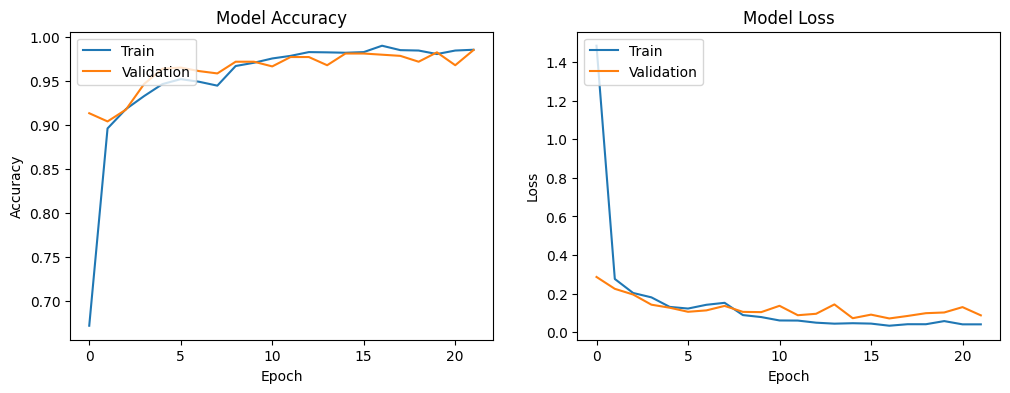

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np

# Plotting the training and validation loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


24/24 [==============================] - 1s 40ms/step
EER for Benjamin_Netanyau: 0.50
EER for Nelson_Mandela: 0.50
EER for Magaret_Tarcher: 0.53
EER for Julia_Gillard: 0.50
EER for Jens_Stoltenberg: 0.52


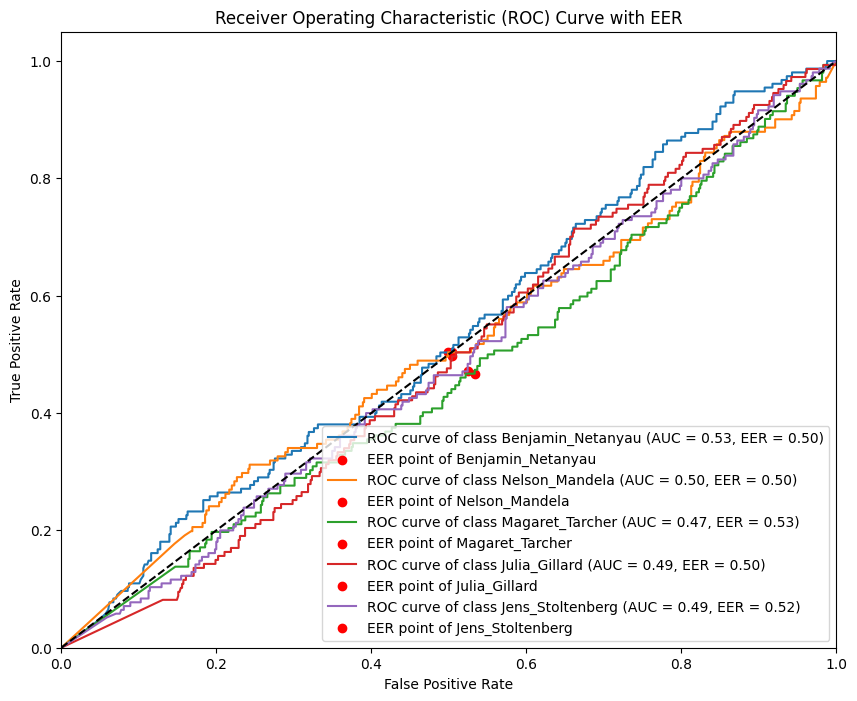

In [ ]:
# EER
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow as tf

# Get the true labels and predicted probabilities
y_true = np.concatenate([y for x, y in valid_ds], axis=0)
y_pred = model.predict(valid_ds)

# Binarize the true labels for ROC computation
y_true_bin = np.eye(len(class_names))[y_true]  # One-hot encode true labels

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred[:, i])

def compute_eer(fpr, tpr, thresholds):
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
    eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    return eer, eer_threshold

eer = dict()
eer_threshold = dict()

for i in range(len(class_names)):
    eer[i], eer_threshold[i] = compute_eer(fpr[i], tpr[i], thresholds[i])

# Print EER for each class
for i in range(len(class_names)):
    print(f'EER for {class_names[i]}: {eer[i]:.2f}')

# Plot ROC curve with EER
plt.figure(figsize=(10, 8))

for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:0.2f}, EER = {eer[i]:0.2f})')
    plt.scatter(fpr[i][np.nanargmin(np.absolute((1 - tpr[i]) - fpr[i]))], tpr[i][np.nanargmin(np.absolute((1 - tpr[i]) - fpr[i]))], marker='o', color='red', label=f'EER point of {class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with EER')
plt.legend(loc="lower right")
plt.show()


In [ ]:
model.save('tuned-model.keras')

# Demo

## Validation prediction

In [ ]:
# Using Validation data (Not external data outside of training)
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

for audios, labels in test_ds.take(1):
    ffts = audio_to_fft(audios)
    y_pred = model.predict(ffts)
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):

        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

4/4 [==============================] - 0s 52ms/step
Speaker: Magaret_Tarcher	Predicted: Benjamin_Netanyau


Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher


Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher


Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau


Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau


Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher


Speaker: Nelson_Mandela	Predicted: Nelson_Mandela


Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg


## Demo V2
Using external data outside of training

You could run just this block for faster use

Resources:

All provided by the help of https://www.americanrhetoric.com/speechbank.htm

Benjamin Netanyau : https://www.americanrhetoric.com/speeches/benjaminnetanyahujointsession2011.htm

Jens Stoltenberg : https://www.americanrhetoric.com/speeches/jensstoltenbergoxfordunion.htm

Julia Gillard : https://www.americanrhetoric.com/speeches/juliagillardjointsessioncongress.htm

Magaret Tarcher : https://www.americanrhetoric.com/speeches/margaretthatcherjointsessioncongress.htm

Nelson Mandela : https://www.americanrhetoric.com/speeches/nelsonmandelainauguralspeech.htm

### First Scenario

```
Value             | Best Value So Far   | Hyperparameter
32                | 64                  | filters_1
128               | 64                  | filters_2
192               | 64                  | filters_3
256               | 256                 | filters_4
128               | 256                 | filters_5
384               | 384                 | dense_units_1
256               | 128                 | dense_units_2
0.000244544596753 | 0.001696            | learning_rate
30                | 4                   | tuner/epochs
10                | 0                   | tuner/initial_epoch
2                 | 2                   | tuner/bracket
2                 | 0                   | tuner/round

```
Parameters that we would use is the Value columns



In [ ]:
# The model tuned based on previous result of hyperparameter tuning
# Do note, that you need to run the preprocessing blocks before this
import keras
import tensorflow as tf

def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)

def build_model3(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 32, 2)      # filters_1
    x = residual_block(x, 128, 2)          # filters_2
    x = residual_block(x, 192, 3)          # filters_3
    x = residual_block(x, 256, 3)          # filters_4
    x = residual_block(x, 128, 3)          # filters_5

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(384, activation="relu")(x)  # dense_units_1
    x = keras.layers.Dense(256, activation="relu")(x)  # dense_units_2

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

def compile_and_train_model3(model, train_data, val_data):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.000244544596753),  # learning_rate
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.summary()

    earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

    history = model.fit(
        train_data,
        epochs=30,                      # tuner/epochs
        initial_epoch=10,               # tuner/initial_epoch
        validation_data=val_data,
        callbacks=[earlystopping_cb]
    )
    return history

# Assuming you have train_ds and valid_ds already prepared
# 16000 Sample Rate, monoaudio
num_speakers = 5
model3 = build_model3((8000, 1), num_speakers)
history3 = compile_and_train_model3(model3, train_ds, valid_ds)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 8000, 32)             128       ['input[0][0]']               
                                                                                                  
 activation (Activation)     (None, 8000, 32)             0         ['conv1d_1[0][0]']            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 8000, 32)             3104      ['activation[0][0]']          
                                                                                              

24/24 [==============================] - 2s 58ms/step
EER for 0: 0.52
EER for 1: 0.50
EER for 2: 0.54
EER for 3: 0.48
EER for 4: 0.49


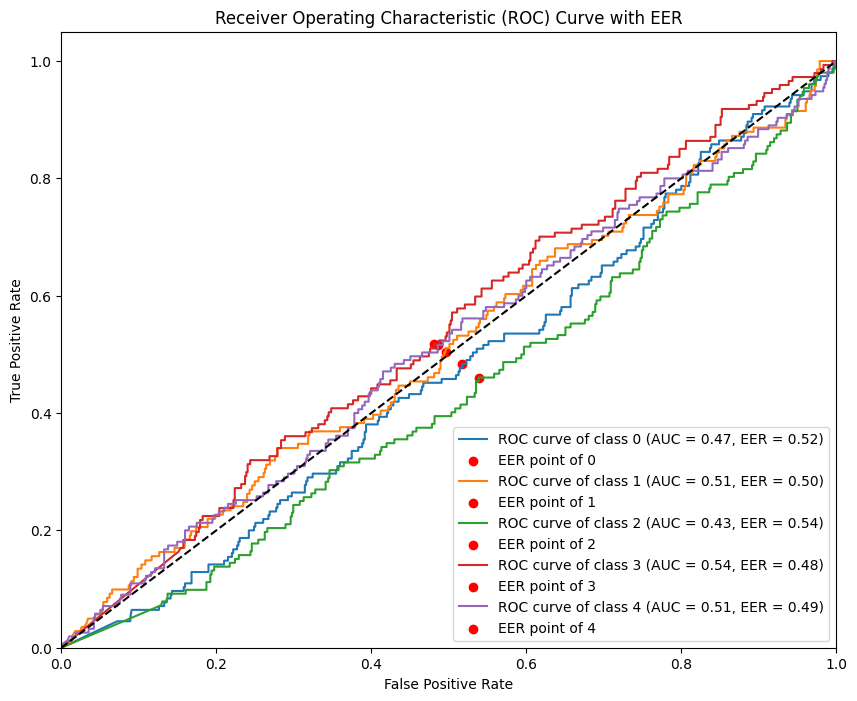

In [ ]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
# EER and ROC Curve Calculation
def compute_eer(fpr, tpr, thresholds):
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
    eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    return eer, eer_threshold

# Get the true labels and predicted probabilities
y_true = np.concatenate([y for x, y in valid_ds], axis=0)
y_pred_probs = model3.predict(valid_ds)

# Binarize the true labels for ROC computation
class_names = [str(i) for i in range(num_speakers)]
y_true_bin = np.eye(len(class_names))[y_true]  # One-hot encode true labels

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
eer = dict()
eer_threshold = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred_probs[:, i])
    eer[i], eer_threshold[i] = compute_eer(fpr[i], tpr[i], thresholds[i])

# Print EER for each class
for i in range(len(class_names)):
    print(f'EER for {class_names[i]}: {eer[i]:.2f}')

# Plot ROC curve with EER
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:0.2f}, EER = {eer[i]:0.2f})')
    plt.scatter(fpr[i][np.nanargmin(np.absolute((1 - tpr[i]) - fpr[i]))], tpr[i][np.nanargmin(np.absolute((1 - tpr[i]) - fpr[i]))], marker='o', color='red', label=f'EER point of {class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with EER')
plt.legend(loc="lower right")
plt.show()

### Second Scenario


```
Value             | Best Value So Far   | Hyperparameter
16                | 64                  | filters_1
128               | 64                  | filters_2
64                | 64                  | filters_3
384               | 256                 | filters_4
128               | 256                 | filters_5
512               | 384                 | dense_units_1
256               | 128                 | dense_units_2
0.000586436011616 | 0.001696            | learning_rate
30                | 4                   | tuner/epochs
10                | 0                   | tuner/initial_epoch
2                 | 2                   | tuner/bracket
3                 | 0                   | tuner/round

```



In [ ]:
import keras
import tensorflow as tf

def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)

def build_model2(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)      # filters_1
    x = residual_block(x, 128, 2)          # filters_2
    x = residual_block(x, 64, 3)           # filters_3
    x = residual_block(x, 384, 3)          # filters_4
    x = residual_block(x, 128, 3)          # filters_5

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(512, activation="relu")(x)  # dense_units_1
    x = keras.layers.Dense(256, activation="relu")(x)  # dense_units_2

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

def compile_and_train_model2(model, train_data, val_data):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.000586436011616),  # learning_rate
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.summary()

    earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

    history = model.fit(
        train_data,
        epochs=30,                      # tuner/epochs
        initial_epoch=10,               # tuner/initial_epoch
        validation_data=val_data,
        callbacks=[earlystopping_cb]
    )
    return history

# Assuming you have train_ds and valid_ds already prepared
# 16000 Sample Rate, monoaudio
num_speakers = 5
model2 = build_model2((8000, 1), num_speakers)
history2 = compile_and_train_model2(model2, train_ds, valid_ds)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_19 (Conv1D)          (None, 8000, 16)             64        ['input[0][0]']               
                                                                                                  
 activation_13 (Activation)  (None, 8000, 16)             0         ['conv1d_19[0][0]']           
                                                                                                  
 conv1d_20 (Conv1D)          (None, 8000, 16)             784       ['activation_13[0][0]']       
                                                                                            

24/24 [==============================] - 2s 51ms/step
EER for 0: 0.47
EER for 1: 0.53
EER for 2: 0.48
EER for 3: 0.49
EER for 4: 0.47


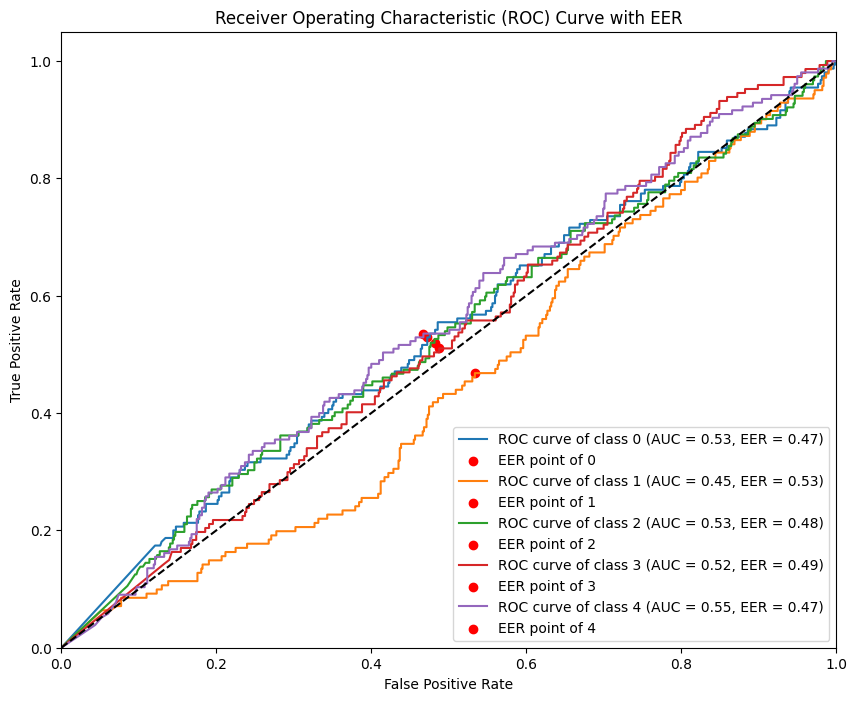

In [ ]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
# EER and ROC Curve Calculation
def compute_eer(fpr, tpr, thresholds):
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
    eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    return eer, eer_threshold

# Get the true labels and predicted probabilities
y_true = np.concatenate([y for x, y in valid_ds], axis=0)
y_pred_probs = model2.predict(valid_ds)

# Binarize the true labels for ROC computation
class_names = [str(i) for i in range(num_speakers)]
y_true_bin = np.eye(len(class_names))[y_true]  # One-hot encode true labels

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
eer = dict()
eer_threshold = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred_probs[:, i])
    eer[i], eer_threshold[i] = compute_eer(fpr[i], tpr[i], thresholds[i])

# Print EER for each class
for i in range(len(class_names)):
    print(f'EER for {class_names[i]}: {eer[i]:.2f}')

# Plot ROC curve with EER
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:0.2f}, EER = {eer[i]:0.2f})')
    plt.scatter(fpr[i][np.nanargmin(np.absolute((1 - tpr[i]) - fpr[i]))], tpr[i][np.nanargmin(np.absolute((1 - tpr[i]) - fpr[i]))], marker='o', color='red', label=f'EER point of {class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with EER')
plt.legend(loc="lower right")
plt.show()

### Predict

In [ ]:
!pip install pydub -q

In [ ]:
# External audio dataset
!gdown 1UfZR-yfVa4xsy3O3nIVaOjQ3JCYUf-6o #Benjamin
!gdown 1YfvJd_maL45O4tkbLZlo0wWDQoE9mEua #StoletenBerg
!gdown 1BSWDW-RxN6eV08S2GawVKD5WcvcI2SwW #Julia
!gdown 1F7rZZqWqDhTvyQvkUJZB-D_qT_q5LMCX #Margaret
!gdown 1-dkmBJAIKTmjQpgyd6hwrk1t7rihDadM #Nelson

Downloading...
From: https://drive.google.com/uc?id=1UfZR-yfVa4xsy3O3nIVaOjQ3JCYUf-6o
To: /content/benjaminnetanyahu2011congress.mp3
100% 43.7M/43.7M [00:01<00:00, 34.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YfvJd_maL45O4tkbLZlo0wWDQoE9mEua
To: /content/jensstoltenbergoxfordunionARXE.mp3
100% 19.4M/19.4M [00:00<00:00, 23.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BSWDW-RxN6eV08S2GawVKD5WcvcI2SwW
To: /content/juliagillardjointsessioncongressARXE.mp3
100% 43.2M/43.2M [00:01<00:00, 28.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1F7rZZqWqDhTvyQvkUJZB-D_qT_q5LMCX
To: /content/margaretthatchercongressjointsession.mp3
100% 30.6M/30.6M [00:00<00:00, 37.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-dkmBJAIKTmjQpgyd6hwrk1t7rihDadM
To: /content/nelsonmandelainauguralspeechARXE.mp3
100% 8.95M/8.95M [00:00<00:00, 19.9MB/s]


In [ ]:
# test folder
!mkdir './Test_dataset'

In [ ]:
# I've uploaded theese dataset into the google drive we would first need to split some of the audio to 1 second long audio data for demo use
from pydub import AudioSegment
import os

def extract_1_second_segment(input_mp3_path, output_audio_path, start_time_ms=0, sample_rate=16000):
    # Load the audio file
    audio = AudioSegment.from_mp3(input_mp3_path)

    # Extract the 1-second segment
    end_time_ms = start_time_ms + 1000
    segment = audio[start_time_ms:end_time_ms]

    # Export the 1-second segment with the specified sample rate
    segment = segment.set_frame_rate(sample_rate)
    segment.export(output_audio_path, format="wav")

def extract_multiple_1_second_segments(input_mp3_paths, output_folder, num_segments=128, sample_rate=16000):
    for input_mp3_path in input_mp3_paths:
        # Get the base name of the file (without directory and extension)
        base_name = os.path.splitext(os.path.basename(input_mp3_path))[0]

        # Create a folder for each speaker
        speaker_folder = os.path.join(output_folder, base_name)
        if not os.path.exists(speaker_folder):
            os.makedirs(speaker_folder)

        # Extract multiple 1-second segments
        for i in range(num_segments):
            start_time_ms = i * 1000
            output_audio_path = os.path.join(speaker_folder, f'segment_{i+1}.wav')
            extract_1_second_segment(input_mp3_path, output_audio_path, start_time_ms, sample_rate)

# List of input MP3 files
input_mp3_paths = [
    '/content/benjaminnetanyahu2011congress.mp3',
    '/content/jensstoltenbergoxfordunionARXE.mp3',
    '/content/juliagillardjointsessioncongressARXE.mp3',
    '/content/margaretthatchercongressjointsession.mp3',
    '/content/nelsonmandelainauguralspeechARXE.mp3'
]

# Output folder
output_folder = 'Test_dataset'

# Extract multiple 1-second segments from each file
extract_multiple_1_second_segments(input_mp3_paths, output_folder, num_segments=5)



### Predict For First Scenario

In [ ]:
# Path to the Test_dataset directory
test_dataset_dir = 'Test_dataset'

# Get the list of audio file paths along with their corresponding labels
valid_audio_paths = []
valid_labels = []
class_names = sorted(os.listdir(test_dataset_dir))  # Ensure consistent ordering
label_map = {name: idx for idx, name in enumerate(class_names)}

for label, name in label_map.items():
    speaker_dir = os.path.join(test_dataset_dir, label)
    if os.path.isdir(speaker_dir):
        for filename in os.listdir(speaker_dir):
            if filename.endswith(".wav"):
                valid_audio_paths.append(os.path.join(speaker_dir, filename))
                valid_labels.append(label_map[label])

# Convert labels to one-hot encoding
num_speakers = len(class_names)
valid_labels_one_hot = tf.keras.utils.to_categorical(valid_labels, num_classes=num_speakers)

# Create test dataset
test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels_one_hot)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(BATCH_SIZE)

test_ds = test_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)


# Amount of samples to display
SAMPLES_TO_DISPLAY = 10

for audios, labels in test_ds.take(1):
    ffts = audio_to_fft(audios)
    y_pred = model3.predict(ffts)
    rnd = np.random.randint(0, 25, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if np.argmax(labels[index]) == y_pred[index] else "[91m",
                class_names[np.argmax(labels[index])],
                "[92m" if np.argmax(labels[index]) == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

1/1 [==============================] - 2s 2s/step
Speaker: juliagillardjointsessioncongressARXE	Predicted: nelsonmandelainauguralspeechARXE


Speaker: jensstoltenbergoxfordunionARXE	Predicted: nelsonmandelainauguralspeechARXE


Speaker: benjaminnetanyahu2011congress	Predicted: jensstoltenbergoxfordunionARXE


Speaker: benjaminnetanyahu2011congress	Predicted: jensstoltenbergoxfordunionARXE


Speaker: jensstoltenbergoxfordunionARXE	Predicted: nelsonmandelainauguralspeechARXE


Speaker: benjaminnetanyahu2011congress	Predicted: jensstoltenbergoxfordunionARXE


Speaker: benjaminnetanyahu2011congress	Predicted: jensstoltenbergoxfordunionARXE


Speaker: juliagillardjointsessioncongressARXE	Predicted: juliagillardjointsessioncongressARXE


Speaker: nelsonmandelainauguralspeechARXE	Predicted: nelsonmandelainauguralspeechARXE


Speaker: nelsonmandelainauguralspeechARXE	Predicted: nelsonmandelainauguralspeechARXE


### Predict for Second Scnario

In [ ]:
SAMPLES_TO_DISPLAY = 10

for audios, labels in test_ds.take(1):
    ffts = audio_to_fft(audios)
    y_pred = model2.predict(ffts)
    rnd = np.random.randint(0, 25, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if np.argmax(labels[index]) == y_pred[index] else "[91m",
                class_names[np.argmax(labels[index])],
                "[92m" if np.argmax(labels[index]) == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

1/1 [==============================] - 3s 3s/step
Speaker: nelsonmandelainauguralspeechARXE	Predicted: nelsonmandelainauguralspeechARXE


Speaker: juliagillardjointsessioncongressARXE	Predicted: juliagillardjointsessioncongressARXE


Speaker: nelsonmandelainauguralspeechARXE	Predicted: nelsonmandelainauguralspeechARXE


Speaker: margaretthatchercongressjointsession	Predicted: benjaminnetanyahu2011congress


Speaker: margaretthatchercongressjointsession	Predicted: benjaminnetanyahu2011congress


Speaker: benjaminnetanyahu2011congress	Predicted: jensstoltenbergoxfordunionARXE


Speaker: jensstoltenbergoxfordunionARXE	Predicted: nelsonmandelainauguralspeechARXE


Speaker: margaretthatchercongressjointsession	Predicted: margaretthatchercongressjointsession


Speaker: juliagillardjointsessioncongressARXE	Predicted: juliagillardjointsessioncongressARXE


Speaker: jensstoltenbergoxfordunionARXE	Predicted: nelsonmandelainauguralspeechARXE
